Using device: cpu
Training MLP on complex function...


  0%|          | 1/400 [00:00<01:10,  5.69it/s]

Epoch    0/400, Train Loss: 0.017148, Test Loss: 0.016101


 50%|█████     | 202/400 [00:26<00:25,  7.92it/s]

Epoch  200/400, Train Loss: 0.000378, Test Loss: 0.000384


100%|██████████| 400/400 [00:50<00:00,  7.86it/s]



Final Test Loss: 0.00007890


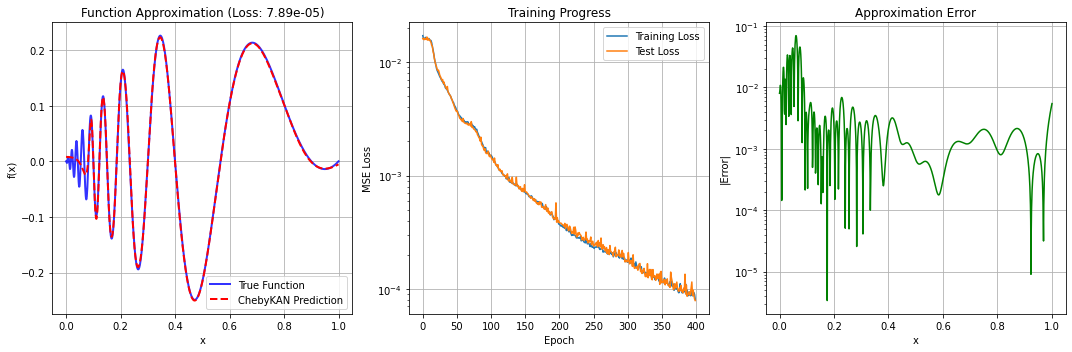


Model Architecture:
MLP(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

Total parameters: 4,353


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define the target function
def target_function(x):
    """f(x) = x*(1-x)*sin(2π/(x+0.1))"""
    return x * (1 - x) * torch.sin((2 * np.pi) / (x + 0.1))

# Your improved ChebyKANLayer
class ChebyKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, degree):
        super(ChebyKANLayer, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.degree = degree

        self.cheby_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree + 1))
        nn.init.normal_(self.cheby_coeffs, mean=0.0, std=1/(input_dim*(degree+1)))
        self.register_buffer("arange", torch.arange(0, degree + 1, 1))

    def forward(self, x):
        # Normalize to [-1, 1] using tanh
        x = torch.tanh(x)
        # View and repeat input degree + 1 times
        x = x.view((-1, self.inputdim, 1)).expand(-1, -1, self.degree + 1)
        # Apply acos and multiply by arange [0..degree]
        x = (x.acos() * self.arange).cos()
        # Compute Chebyshev interpolation using einsum
        y = torch.einsum("bid,iod->bo", x, self.cheby_coeffs)
        return y.view(-1, self.outdim)

# Standard 3-layer MLP
class MLP(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)


# Create dataset
def create_dataset(num_samples=1000):
    x = torch.rand(num_samples, 1)  # Input in [0, 1]
    y = target_function(x)  # Target values
    return x, y

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(input_dim=1, hidden_dim=64, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.5)

# Create data
X_train, y_train = create_dataset(5000)
X_test = torch.linspace(0, 1, 1000).unsqueeze(1)
y_test = target_function(X_test)

# Move data to device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Training loop
num_epochs = 400
batch_size = 64
losses = []
test_losses = []

print("Training MLP on complex function...")
for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = 0

    # Mini-batch training
    permutation = torch.randperm(X_train.size(0))
    for i in range(0, X_train.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_x = X_train[indices]
        batch_y = y_train[indices]

        # Forward pass
        predictions = model(batch_x)
        loss = criterion(predictions, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Average loss for the epoch
    avg_loss = epoch_loss / (X_train.size(0) / batch_size)
    losses.append(avg_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test)
        test_loss = criterion(test_pred, y_test).item()
        test_losses.append(test_loss)

    scheduler.step(test_loss)

    if epoch % 200 == 0:
        tqdm.write(f'Epoch {epoch:4d}/{num_epochs}, Train Loss: {avg_loss:.6f}, Test Loss: {test_loss:.6f}')

# Final evaluation
model.eval()
with torch.no_grad():
    final_predictions = model(X_test)
    final_loss = criterion(final_predictions, y_test).item()

print(f"\nFinal Test Loss: {final_loss:.8f}")

# Visualization
plt.figure(figsize=(15, 5))

# Plot 1: Function approximation
plt.subplot(1, 3, 1)
plt.plot(X_test.cpu().numpy(), y_test.cpu().numpy(), 'b-', label='True Function', linewidth=2, alpha=0.8)
plt.plot(X_test.cpu().numpy(), final_predictions.cpu().numpy(), 'r--', label='ChebyKAN Prediction', linewidth=2)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(f'Function Approximation (Loss: {final_loss:.2e})')
plt.legend()
plt.grid(True)

# Plot 2: Training and test loss
plt.subplot(1, 3, 2)
plt.plot(losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Progress')
plt.yscale('log')
plt.legend()
plt.grid(True)

# Plot 3: Absolute error
plt.subplot(1, 3, 3)
abs_error = torch.abs(final_predictions - y_test).cpu().numpy()
plt.plot(X_test.cpu().numpy(), abs_error, 'g-', label='Absolute Error')
plt.xlabel('x')
plt.ylabel('|Error|')
plt.title('Approximation Error')
plt.yscale('log')
plt.grid(True)

plt.tight_layout()
plt.show()

# Show model architecture and parameters
print(f"\nModel Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")